1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

half_lieve = 3.052*60
N0_Tl = 1000
N0_Pb = 0

time = np.arange(0, half_lieve*10, 1)

N_Tl = []
N_Pb = []

for t in time:
    for j in range(N0_Tl):
        extraction = np.random.uniform()
        if extraction < 1-2**(-1./half_lieve):
            N0_Tl -= 1
            N0_Pb += 1 

    N_Tl.append(N0_Tl)
    N_Pb.append(N0_Pb)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Atoms')

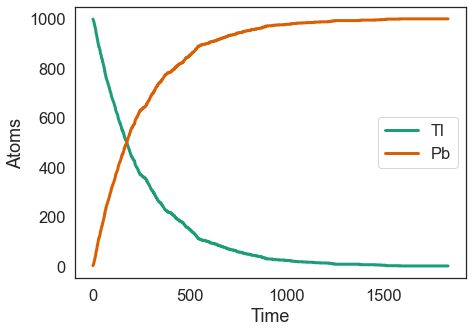

In [43]:
fig, ax = plt.subplots( figsize=(7, 5))
lw=3
sns.set_theme(style="white", font_scale=1.5, palette='Dark2')
sns.lineplot(time, N_Tl, label='Tl', ax=ax, lw=lw)
sns.lineplot(time, N_Pb, label='Pb', ax=ax, lw=lw)
ax.set_xlabel('Time')
ax.set_ylabel('Atoms')

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [11]:
#natuaral units
a_0 = 5.29e4 
sigma = a_0/100.
N = int(1e4)
x = np.random.normal(0, sigma, N)
y = np.random.normal(0, sigma, N)
epsilon_0 = 1

def theta(x,y):
    Z = 79
    e =  1
    E = 7.7 
    b = np.sqrt(x**2 + y**2)
    return 2*np.arctan((2*Z*e**2)/(E*b))

angles = theta(x, y)
accepted = angles[np.where(angles < np.pi/2)]
rejected = angles[np.where(angles >= np.pi/2)]

print('fraction Accepted: ', len(accepted)/N)
print('fraction rejected: ', len(rejected)/N)


fraction Accepted:  0.9993
fraction rejected:  0.0007


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [12]:
ybounds = [0,1]
xbounds = [0,2]
real_value = 1.4514

def f (x):
    return np.sin(1./(x*(2-x)))**2

N_samples =  100000
accepted = []
integral = []
for n in range(N):
    x = np.random.uniform(xbounds[0], xbounds[1])
    y = np.random.uniform(ybounds[0], ybounds[1])
    if y<f(x): accepted.append([x, y])

int = len(accepted)/N_samples*2
print('integral:', int)
print('error:', abs(real_value-int))
print('the error should scale with 1/sqrt(N_samples)')


integral: 0.14436
error: 1.30704
the error should scale with 1/sqrt(N_samples)


In [13]:
x_rand = np.random.uniform(low=xbounds[0], high=xbounds[1], size=N_samples)
int_mean = (xbounds[1]-xbounds[0])/N_samples * np.sum(f(x_rand))
print('integral:', int_mean)
print('error:', abs(real_value-int_mean))

integral: 1.4509321556111257
error: 0.0004678443888743722


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [14]:
# area 
N = 100000

xbound, ybound = [-1,1], [-1,1]
xrand = np.random.uniform(low=xbound[0], high=xbound[1], size=N)
yrand = np.random.uniform(low=ybound[0], high=ybound[1], size=N)

def sphere (x, y):
    if x**2+y**2 <= 1: return 1
    else: return 0

f_eval = [sphere(x, y) for x,y in zip(xrand, yrand)]
int_mean = (xbound[1]-xbound[0])*(ybound[1]-ybound[0])/N * np.sum(f_eval)

real_value = 4./3.*np.pi
print('integral:', int_mean)
print('real value:', real_value)
print('error:', abs(real_value-int_mean))

integral: 3.14428
real value: 4.1887902047863905
error: 1.0445102047863903


In [15]:
# area 
N = 1000000
dim = 10
bounds = [-1,1]
rand = np.random.uniform(low=bounds[0], high=bounds[1], size=(N, dim))

def dsphere (x):
    if np.sum([i**2 for i in x])<= 1: return 1
    else: return 0

f_eval = [dsphere(x) for x in rand]
int_mean = (bounds[1]-bounds[0])**dim/N * np.sum(f_eval)
print('dim 10 sphere:', int_mean)

dim 10 sphere: 2.541568


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [16]:
N_samples = 100000
interval = (0,1)
xrand = np.random.uniform(low=interval[0], high=interval[1], size=N_samples)

def function (x):
    return x**(-0.5)/(np.exp(x) + 1)

def w (x): return 1/np.sqrt(x)
def inv_w(x): return x**2

ws = inv_w(xrand)
integral = (1./N_samples)*np.sum(np.divide(function(ws),w(ws)))*2.
integral

0.8385805609553357